In [1]:
import numpy as np
import pickle
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
import warnings

warnings.filterwarnings(action='ignore')

In [220]:
def read_csv(path, epsilon):
    epsilon = str(epsilon)
    csv_name = 'comparison_data_'+epsilon+'.csv'
    data = pd.read_csv(path.joinpath(csv_name))
    return data

#PROJ_PATH = Path('/home/dogu86/colon_synthesis_2')
INPUT_PATH = Path("/mnt/synthetic_data/lung/data/processed/4_evaluate/make_death/")

In [718]:
#s1 = pd.read_pickle('/home/dogu86/colon_synthesis_2/data/processed/2_restore/restore_to_s1/D1/S1_1.pkl')

In [135]:
def pre_process(data):
    encoding = pd.read_pickle('/home/dogu86/lung_synthesis/data/processed/0_preprocess/encoding.pkl')
    for key in list(encoding.keys()):
        if 'PT_BSNF' in key:
            name = key[8:]
            encoding[name]=encoding.pop(key)
    return data.replace(encoding).replace(np.NaN,0).astype(float).astype(int)

In [267]:
# input : dataframe or series
# output: 
def iqr_outlier_drop(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3-q1
    iqr_step = iqr*1.5
    condition1 = df<(q3+iqr_step)
    condition2 = df>(q1-iqr_step)
    
    return (df[condition1 & condition2])

# input : original dataframe, target column
# return : dataframe, iqr droped in traget column
def iqr_drop(df, col):
    df = df.reset_index()
    df = df.drop('index',axis=1)
    idx = iqr_outler_drop(df[col]).index
    df = df.loc[idx]
    
    return df


# input : original x, list of target columns
# return : encdoded x
def label_encoding(data, ordinal):
    encoder = LabelEncoder()
    
    for col in ordinal:
        encoded = encoder.fit_transform(data[col])
        data[col] = encoded
    
    return data

def scale(data):
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    
    return data
    
    
def ml_train(data, model, epsilon, save = False, importance = False):
    
    
    data = data.astype(float)
    
    '''    
    y_test_1 = (data['DEAD']==False).sample(n=130, random_state =123)
    y_test_0 = (data['DEAD']==True).sample(n=170, random_state =123)
    y_test = pd.concat([y_test_1,y_test_0])
    y_train = data.drop(y_test.index)['DEAD']
    print(y_test)
    x_train = data.loc[y_train.index].drop(['DEAD'], axis=1)
    x_test = data.loc[y_test.index].drop(['DEAD'], axis=1)
    '''
    
#    x = data.drop(['DEAD'],axis=1)
    x = data.drop(['DEAD'], axis=1)
    y = data['DEAD']
    
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25,random_state=123, stratify = y)
    
    feature = x_train.columns
    
    x_test = scale(x_test)
    x_train = scale(x_train)
    '''
    grid_parameters = {"max_depth": [20, 30, 80,100],
                       "min_samples_split": [2, 3]
                       }

    model = GridSearchCV(model, param_grid=grid_parameters, cv=3, refit=True)
    '''
    from sklearn.model_selection import cross_val_predict
    pred = cross_val_predict(model, x_test, y_test, cv=3)
    
    
    #smote = SMOTE(random_state=42)
    #x_train, y_train = smote.fit_resample(x_train, y_train)
    #print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
    #print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
#    pred_proba = model.predict_proba(x_test)[:,-1]
    if (save == True):
        with open('clf_model'+str(epsilon)+'.pkl','wb') as fw:
            pickle.dump(model, fw)
    f1 = f1_score(y_test,pred)
    acc = accuracy_score(y_test,pred)
    roc = roc_auc_score(y_test,pred)
#    print("f1 score : ",f1)
#    print("accuracy : ", acc)
#    print("auc : ", roc)
    
    cf = confusion_matrix(y_test, pred)
#    print(cf)
    
    if importance == True:
        import seaborn as sns

        importances = model.feature_importances_

        plt.figure(figsize=(10, 8))
        sns.barplot(x=importances, y=feature)
        plt.title('Random Forest Feature Importances', fontsize=18)
        plt.show()
    
    return [model,[f1,acc,roc]]
    
    
def get_roc(pred,y,pred_proba,model):
    roc_auc = roc_auc_score(y, pred)
    sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
    from sklearn.metrics import roc_curve
    pred_proba = model.predict_proba(x_test_fin)[:, 1]
    FPR, TPR, _ = roc_curve(y_test_fin, pred_proba)
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.plot(FPR, TPR, lw =2, label = 'AUC = %0.3f'% roc_auc)
    plt.plot([0,1],[0,1],'--', color='black')
#    plt.title('ROC Curve (epsilon=' + str(ep) +')')
    plt.xlabel('Specificity')
    plt.ylabel('Sensitivity')
    plt.legend()
    plt.show()

def plot_tree(model, x):
    from sklearn.tree import plot_tree
    plt.figure(figsize=(20,15))
    plot_tree(model, max_depth = 2, feature_names=list(x.columns),
            class_names=['Survive','Dead'],
            impurity=True, filled=True,
            rounded=True)
    #plt.savefig('figs/decision tree plot.png')
    #plt.clf()
    plt.show()
    

def plot_graph(pred_real_to_real, syn_to_real, name, bar=True):
    nrow = 5 # 행의 갯수
    w = 0.25
    idx = np.arange(nrow)
    plt.figure(figsize=(16,5))
    plt.bar([-1.1],[pred_real_to_real[0]], width=w, color = 'yellowgreen', label = 'F1 Score, real')
    plt.bar([-1.1+w],[pred_real_to_real[2]], width=w, color = 'seagreen', label = 'AUC Score, real')
    plt.bar(idx -w*2+0.4, np.transpose(syn_to_real)[0], width = w, color = 'darkred', label = 'F1 Score, TSTR')
    plt.bar(idx -w+ 0.4, np.transpose(syn_to_real)[2], width = w, label = 'AUC Score, TSTR' ,color ='lightcoral')

    plt.plot(idx - w +0.4, np.transpose(syn_to_real)[2],color ='lightcoral')
    plt.plot(idx - w*2 +0.4, np.transpose(syn_to_real)[0],color = 'darkred')
    plt.xticks(np.arange(-2,6,1),['', 'real' ,'0.1','1','10','100','1000','10000'])

    plt.axhline([pred_real_to_real[2]], 0.15, 0.95,color = 'seagreen', linestyle = '--')
    plt.axhline([pred_real_to_real[0]], 0.1, 0.95,color = 'yellowgreen', linestyle = '--')
    x = np.arange(-2,6,1)

    plt.legend()
    plt.ylabel = 'Scores'
    plt.xlabel = 'Epsilon'
    plt.title(name + ' TSTR Results - Lung Cancer')
    
    

In [1208]:
len(real.loc[real.DEAD == 0])/len(real.loc[real.DEAD == 1])

11.61344537815126

In [6]:
def get_syn_data(sampling = False):
    syn_data = []
    epsilons = [0.1,1,10,100,1000]
    for epsilon in epsilons:
        if sampling == False:
            temp_syn = pre_process(read_csv(INPUT_PATH, epsilon))
            syn_data.append(temp_syn)

        # under sampling synthetic data for comparsion
        elif sampling == True:
            temp_syn = pre_process(read_csv(INPUT_PATH, epsilon))
            
            dead_syn = temp_syn.loc[temp_syn.DEAD == 1]
            dead_sample = int(len(dead_syn)/5)

            dead_syn = dead_syn.sample(n=dead_sample,replace=True)

            survive_syn = temp_syn.loc[temp_syn.DEAD == 0].sample(n=int(dead_sample*11.613), replace = True)

            syn_data.append(pd.concat([dead_syn, survive_syn]))
            
    return syn_data


In [106]:
def output(real, syn_data,model, bar=True):
    target = 'DEAD'

    name = str(model).split('C')[0]
    syn_to_real = []
    syn_to_syn = []

    real_y = real[target]
    real_x = real.drop([target],axis=1)

    # encoding ordinal columns
    #real_x = label_encoding(real_x, [['BSPT_SEX_CD']])
    real_x = scale(real_x)

    dt_real = ml_train(real ,model, epsilon =1)
    dt_real_model = dt_real[0]
    pred_real_to_real = dt_real[1]

    epsilons = [0.1,1,10,100,1000]
    
    
    real[target]
    
    for i, syn in enumerate(syn_data):
        dt_syn = ml_train(syn, model,epsilon=epsilons[i], save = True)
        dt_syn_model = dt_syn[0]
        syn_score = dt_syn[1]
        # evaluate real value from modeled in synthesized
        
        # real value
        pred_syn_to_real = dt_syn_model.predict(real_x)

        tstr_score = [f1_score(real_y,pred_syn_to_real),
                      accuracy_score(real_y,pred_syn_to_real),
                      roc_auc_score(real_y,pred_syn_to_real) ]

        #f1, acc, roc
        syn_to_syn.append(syn_score)
        syn_to_real.append(tstr_score)

    plot_graph(pred_real_to_real, syn_to_real, name, bar)
    return [syn_to_real, pred_real_to_real]
    

In [107]:
# ------------------------- #


In [222]:
# main


real = pre_process(pd.read_csv('/mnt/synthetic_data/lung/data/processed/4_evaluate/make_death/original.csv'))

#for _ in range(2):
#    real = pd.concat([real,real.copy()])

syn_data = get_syn_data(sampling = False)

Processing ...LogisticRegression()
Done 1 / 4
Processing ...DecisionTree
Done 2 / 4
Processing ...RandomForest
Done 3 / 4
Processing ...KNeighbors
Done 4 / 4


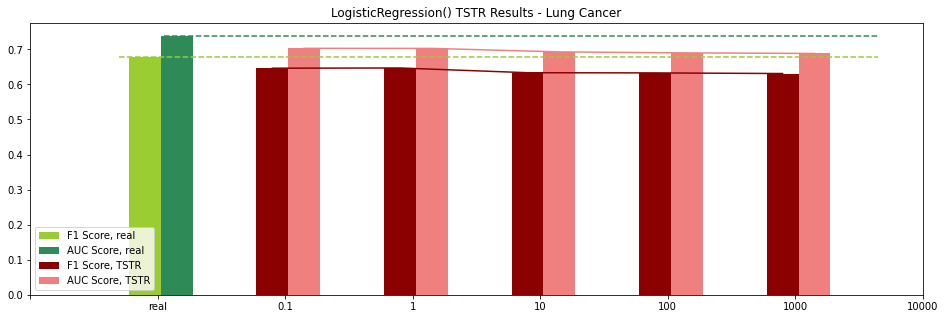

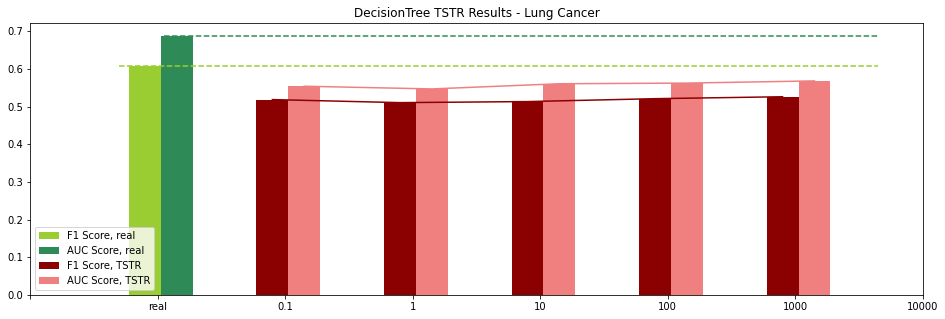

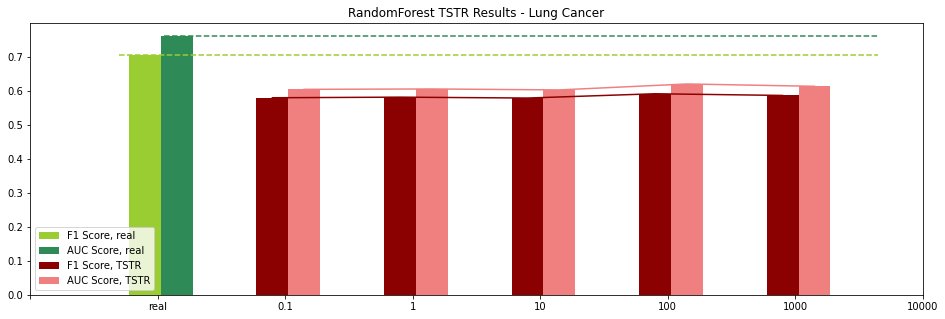

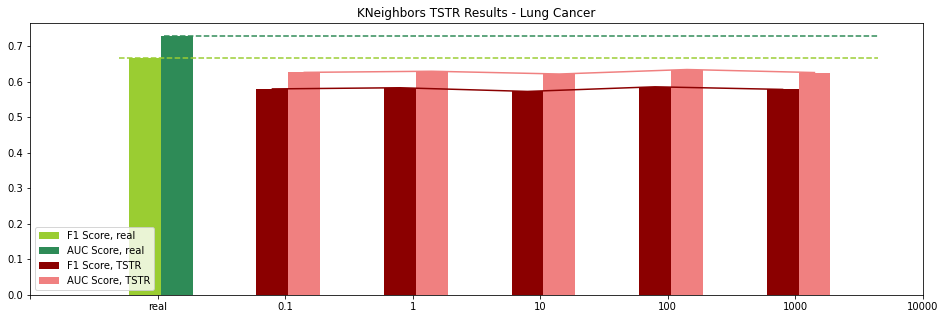

In [268]:
models = [LogisticRegression(penalty = 'l2'),
          DecisionTreeClassifier(max_depth=40,min_samples_split=6,min_samples_leaf=1),
          RandomForestClassifier(max_depth=30,min_samples_split=8,min_samples_leaf=1),
          KNeighborsClassifier()]

tstr_scores = []
real_scores = []
for i, model in enumerate(models):
    print(f'Processing ...'+ str(model).split('C')[0])
    result = output(real, syn_data, model)
    
    tstr = result[0]
    real_score = result[1]
    
    tstr_scores.append(tstr)
    real_scores.append(real_score)
    print(f'Done {i+1} / {len(models)}')
    

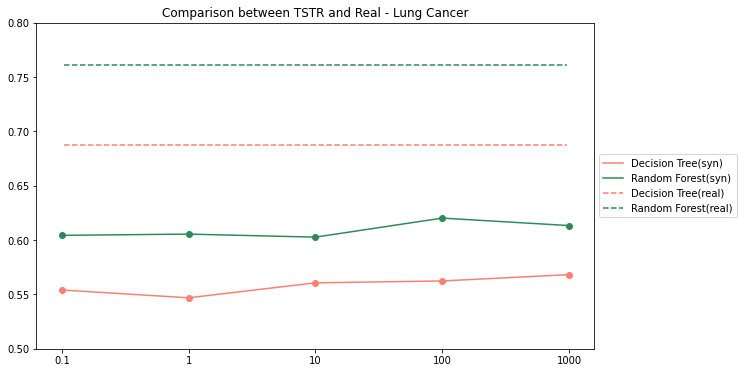

In [274]:
model_name = ['Logistic Regression','Decision Tree','Random Forest','KNN']
colors = ['dodgerblue','salmon','seagreen','mediumorchid']
plt.figure(figsize=(10,6))
for i in [1,2]:
    plt.plot(np.transpose(tstr_scores[i])[2],label = model_name[i]+'(syn)', color = colors[i])
    plt.scatter(np.arange(0,5,1),np.transpose(np.transpose(tstr_scores[i])[2]), color = colors[i])
#    plt.scatter(np.transpose(tstr_scores[i])[2])
#plt.plot(np.transpose(tstr_scores[0])[2],label = 'Logistic Regression')
#plt.plot(np.transpose(tstr_scores[1])[2],label = 'Decision Tree')
#plt.plot(np.transpose(tstr_scores[2])[2],label = 'Random Forest')
#plt.plot(np.transpose(tstr_scores[3])[2],label = 'KNN')


for i in [1,2]:
    plt.axhline(np.transpose(real_scores)[2][i], 0.05, 0.95,  linestyle = '--', label = model_name[i]+'(real)', color = colors[i])

plt.xticks(np.arange(0,5,1),['0.1','1','10','100','1000'])
#plt.plot(np.transpose(tstr_scores[3])[2], label = 'F1 Score')
plt.legend()
plt.xlabel ='Epsilon'
plt.ylabel='AUC Score'
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0.5, 0.8)
plt.title('Comparison between TSTR and Real - Lung Cancer')
plt.show()

In [1192]:
np.transpose(tstr_scores[2])[2]

array([0.55773815, 0.60707293, 0.5878735 , 0.59482968, 0.66097119,
       0.61018923])

In [ ]:
[0.1, 1, 3, 5, 7, 10 ,10000]


In [192]:
real

,PT_SBST_NO,BSPT_SEX_CD,BSPT_FRST_DIAG_CD,BSPT_AGE,BSPT_STAG_VL,BSPT_T_STAG_VL,BSPT_N_STAG_VL,BSPT_M_STAG_VL,BSPT_OPRT,TRTM_RD_RDT,OVRL_DAYS,DEAD
0,8183,0,1,77,4,2,1,1,0,0,86,1
1,1889,0,1,77,3,3,2,0,0,1,1117,1
2,9219,1,1,73,1,2,0,0,1,0,1836,0
3,10936,1,3,63,1,1,0,0,0,0,217,0
4,4855,0,0,60,2,2,0,0,0,0,1998,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11143,5496,0,5,60,4,4,2,1,0,1,80,1
11144,3108,0,1,61,4,2,3,1,0,1,332,0
11145,8947,1,0,64,1,1,0,0,1,0,774,0
11146,8686,1,1,76,4,2,1,1,0,0,42,0


In [123]:
real

,PT_SBST_NO,BSPT_SEX_CD,BSPT_FRST_DIAG_CD,BSPT_AGE,BSPT_STAG_VL,BSPT_T_STAG_VL,BSPT_N_STAG_VL,BSPT_M_STAG_VL,BSPT_OPRT,TRTM_RD_RDT,OVRL_DAYS,DEAD
0,8183,0,1,77,4,2,1,1,0,0,86,1
1,1889,0,1,77,3,3,2,0,0,1,1117,1
2,9219,1,1,73,1,2,0,0,1,0,1836,0
3,10936,1,3,63,1,1,0,0,0,0,217,0
4,4855,0,0,60,2,2,0,0,0,0,1998,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11143,5496,0,5,60,4,4,2,1,0,1,80,1
11144,3108,0,1,61,4,2,3,1,0,1,332,0
11145,8947,1,0,64,1,1,0,0,1,0,774,0
11146,8686,1,1,76,4,2,1,1,0,0,42,0


In [124]:
real.DEAD.value_counts()


0    6714
1    4095
Name: DEAD, dtype: int64

In [1266]:
b = pd.read_csv('/mnt/synthetic_data/data/processed/4_evaluate/make_whole_data/D0/S0_comparsion_data_1.csv')


In [227]:
syn_data[0]

,PT_SBST_NO,BSPT_SEX_CD,BSPT_FRST_DIAG_CD,BSPT_AGE,BSPT_STAG_VL,BSPT_T_STAG_VL,BSPT_N_STAG_VL,BSPT_M_STAG_VL,BSPT_OPRT,TRTM_RD_RDT,OVRL_DAYS,DEAD
0,0,1,1,43,2,2,0,0,1,0,3521,1
1,1,1,0,66,4,2,0,1,0,1,2820,0
2,10,0,0,66,4,2,1,1,0,1,546,1
3,100,0,0,55,1,1,0,0,1,0,0,0
4,1000,0,0,53,4,2,2,1,0,0,294,0
...,...,...,...,...,...,...,...,...,...,...,...,...
45565,9995,1,0,51,3,2,2,0,0,0,2412,0
45566,9996,0,1,64,3,2,3,0,0,0,696,1
45567,9997,1,1,68,4,4,0,1,0,1,658,1
45568,9998,0,0,66,4,2,2,1,0,0,1979,1


In [193]:
a = pd.read_pickle('/mnt/synthetic_data/lung/data/processed/2_restore/restore_to_s1/S1_0.1.pkl')

In [196]:
a.PT_SBST_NO.nunique()

45570

In [197]:
syn_data[4]

,PT_SBST_NO,BSPT_SEX_CD,BSPT_FRST_DIAG_CD,BSPT_AGE,BSPT_STAG_VL,BSPT_T_STAG_VL,BSPT_N_STAG_VL,BSPT_M_STAG_VL,BSPT_OPRT,TRTM_RD_RDT,OVRL_DAYS,DEAD
0,0,1,1,43,2,2,0,0,0,0,1633,1
1,1,1,0,66,4,2,0,1,1,1,2582,0
2,1001,0,1,74,4,4,3,1,0,0,654,1
3,1003,0,1,56,4,2,2,1,0,1,1756,1
4,1004,1,1,65,2,3,0,0,0,0,200,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5142,993,1,0,47,4,4,0,1,0,1,223,1
5143,994,1,1,52,2,1,1,0,0,0,2978,0
5144,995,0,0,73,4,2,1,1,0,1,0,0
5145,996,0,1,37,4,4,3,1,0,0,21,0


In [ ]:
# 하나로부터 합성된 데이터 n개의 데이터가 진짜로 다른지?
# 전체 데이터(원본) 두개 다



In [1148]:
for i in [0,1,2,3]:
    temp = pd.read_pickle(f'/mnt/synthetic_data/data/processed/1_apply_bayesian/produce_data/D0/epsilon100/synthetic_data_{i}_sample.pkl')
    temp.to_csv(f'/home/dogu86/synthetic_sample2/epsilon100_syn_{i}.csv')
    
    

In [1143]:
org = pd.read_csv('/mnt/synthetic_data/data/processed/1_apply_bayesian/preprocess_data/D0/pt_1314.csv')

org.to_csv('/home/dogu86/synthetic_sample2/original_pt.csv')


In [1126]:
import os

for file in os.listdir('/mnt/synthetic_data/data/processed/1_apply_bayesian/produce_data/D0/epsilon10'):
    if 'sample' in file:
        print(file)
        
        

synthetic_data_0_sample.pkl
synthetic_data_2_sample.pkl
synthetic_data_1_sample.pkl
synthetic_data_3_sample.pkl


In [198]:
pd.read_pickle('/mnt/synthetic_data/lung/data/processed/2_restore/restore_to_s1/S1_10.pkl').nunique()


PT_SBST_NO                           45570
TIME                                  3123
EX_PLMN_FEV1_FVC_P                      71
EX_PLMN_FEV1_L                         255
EX_PLMN_FEV1_P                          98
EX_PLMN_FVC_L                          299
EX_PLMN_FVC_P                          103
OPRT_NFRM_OPRT_LUCN_OPRT_KIND_CD        28
PT_BSNF_BSPT_SEX_CD                      2
PT_BSNF_BSPT_FRST_DIAG_CD                6
PT_BSNF_BSPT_STAG_VL                     8
PT_BSNF_BSPT_T_STAG_VL                   6
PT_BSNF_BSPT_N_STAG_VL                   6
PT_BSNF_BSPT_M_STAG_VL                   3
PT_BSNF_BSPT_AGE                        76
PT_BSNF_BSPT_FRST_DIAG_YMD               2
PTH_BPSY_BPTH_SITE_CONT                  4
PTH_BPSY_BPTH_BPSY_MTHD_DETL_CONT        3
PTH_MLCR_MLPT_KIND_NM                    3
PTH_MLCR_MLPT_RSLT_CONT                  2
PTH_MNTY_IMPT_KIND_NM                   23
PTH_MNTY_IMPT_RSLT_CONT                  5
PTH_SRGC_SGPT_LUNGM_SIZE_VL             66
PTH_SRGC_SG

In [1239]:
len(os.listdir('/mnt/synthetic_data/data/processed/1_apply_bayesian/produce_data/D0/epsilon1'))

95434

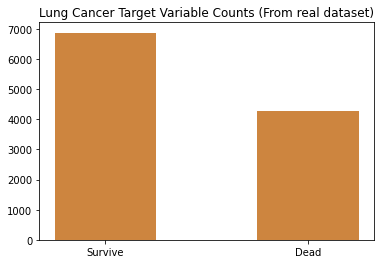

In [264]:
plt.bar([1,2],real.DEAD.value_counts(), width = 0.5, color = 'peru')
plt.title('Lung Cancer Target Variable Counts (From real dataset)')
plt.xticks(np.arange(1,3,1),['Survive','Dead'])
plt.ylabel = 'counts'


In [249]:
nrow = 2 # 행의 갯수
w = 0.25
idx = np.arange(nrow)
plt.figure(figsize=(16,5))
plt.bar([-1.1],[real.DEAD.value_counts()], width=w, color = 'yellowgreen', label = 'F1 Score, real')
plt.bar([-1.1+w],[pred_real_to_real[2]], width=w, color = 'seagreen', label = 'AUC Score, real')
plt.bar(idx -w*2+0.4, np.transpose(syn_to_real)[0], width = w, color = 'darkred', label = 'F1 Score, TSTR')
plt.xticks(np.arange(-2,6,1),['', 'real' ,'0.1','1','10','100','1000','10000'])


plt.legend()
plt.ylabel('Scores')
plt.xlabel('Epsilon')
plt.title(name + ' TSTR Results')
    

NameError: name 'pred_real_to_real' is not defined

<Figure size 1152x360 with 0 Axes>

In [272]:
real

,PT_SBST_NO,BSPT_SEX_CD,BSPT_FRST_DIAG_CD,BSPT_AGE,BSPT_STAG_VL,BSPT_T_STAG_VL,BSPT_N_STAG_VL,BSPT_M_STAG_VL,BSPT_OPRT,TRTM_RD_RDT,OVRL_DAYS,DEAD
0,8183,0,1,77,4,2,1,1,0,0,86,1
1,1889,0,1,77,3,3,2,0,0,1,1117,1
2,9219,1,1,73,1,2,0,0,1,0,1836,0
3,10936,1,3,63,1,1,0,0,0,0,217,0
4,4855,0,0,60,2,2,0,0,0,0,1998,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11143,5496,0,5,60,4,4,2,1,0,1,80,1
11144,3108,0,1,61,4,2,3,1,0,1,332,0
11145,8947,1,0,64,1,1,0,0,1,0,774,0
11146,8686,1,1,76,4,2,1,1,0,0,42,0


In [273]:
syn_data[0]

,PT_SBST_NO,BSPT_SEX_CD,BSPT_FRST_DIAG_CD,BSPT_AGE,BSPT_STAG_VL,BSPT_T_STAG_VL,BSPT_N_STAG_VL,BSPT_M_STAG_VL,BSPT_OPRT,TRTM_RD_RDT,OVRL_DAYS,DEAD
0,0,1,1,43,2,2,0,0,1,0,3521,1
1,1,1,0,66,4,2,0,1,0,1,2820,0
2,10,0,0,66,4,2,1,1,0,1,546,1
3,100,0,0,55,1,1,0,0,1,0,0,0
4,1000,0,0,53,4,2,2,1,0,0,294,0
...,...,...,...,...,...,...,...,...,...,...,...,...
45565,9995,1,0,51,3,2,2,0,0,0,2412,0
45566,9996,0,1,64,3,2,3,0,0,0,696,1
45567,9997,1,1,68,4,4,0,1,0,1,658,1
45568,9998,0,0,66,4,2,2,1,0,0,1979,1
